# KAGGLE - AIRBNB new user bookings

In [1]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

### Data and challenge https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data
In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

### import data

In [2]:
#zf = zipfile.ZipFile('airbnb-recruiting-new-user-bookings.zip') 
df_age_gender = pd.read_csv(r'airbnb-recruiting-new-user-bookings\age_gender_bkts.csv')
df_countries = pd.read_csv(r'airbnb-recruiting-new-user-bookings\countries.csv\countries.csv')
df_sessions = pd.read_csv(r'airbnb-recruiting-new-user-bookings\sessions.csv\sessions.csv')
df_test = pd.read_csv(r'airbnb-recruiting-new-user-bookings\test_users.csv\test_users.csv')
df_train = pd.read_csv(r'airbnb-recruiting-new-user-bookings\train_users_2.csv\train_users_2.csv')
df_sub_NDF = pd.read_csv(r'airbnb-recruiting-new-user-bookings\sample_submission_NDF.csv\sample_submission_NDF.csv')

In [3]:
print('Shape: age-gender',df_age_gender.shape)
print('Shape: countries',df_countries.shape)
print('Shape: sessions',df_sessions.shape)
print('Shape: test',df_test.shape)
print('Shape: train',df_train.shape)
print('Shape: NDF',df_sub_NDF.shape)

Shape: age-gender (420, 5)
Shape: countries (10, 7)
Shape: sessions (10567737, 6)
Shape: test (62096, 15)
Shape: train (213451, 16)
Shape: NDF (62096, 2)


In [601]:
df_sub_NDF.head()

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF


In [605]:
df_test[df_test['id'] == '5uwns89zht']

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari


### EDA data sets
* clean train and test set (possibly need to fill gaps)
* feature engineering to add features to train and test set 

In [4]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
df_train.nunique()

id                         213451
date_account_created         1634
timestamp_first_active     213451
date_first_booking           1976
gender                          4
age                           127
signup_method                   3
signup_flow                    17
language                       25
affiliate_channel               8
affiliate_provider             18
first_affiliate_tracked         7
signup_app                      4
first_device_type               9
first_browser                  52
country_destination            12
dtype: int64

In [6]:
df_countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [7]:
df_age_gender.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [8]:
df_age_gender.groupby('country_destination')['population_in_thousands'].sum().sort_values(ascending=False)
# matches total population of those countries

country_destination
US    325132.0
DE     82562.0
FR     64983.0
GB     63840.0
IT     61145.0
ES     47203.0
CA     35871.0
AU     23923.0
NL     16848.0
PT     10609.0
Name: population_in_thousands, dtype: float64

In [9]:
df_age_gender[df_age_gender['country_destination'] == 'US'].sort_values(by=['gender','age_bucket']).head()

,age_bucket,country_destination,gender,population_in_thousands,year
408,0-4,US,female,10306.0,2015.0
387,10-14,US,female,10346.0,2015.0
396,100+,US,female,61.0,2015.0
417,15-19,US,female,10570.0,2015.0
413,20-24,US,female,11094.0,2015.0


In [10]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


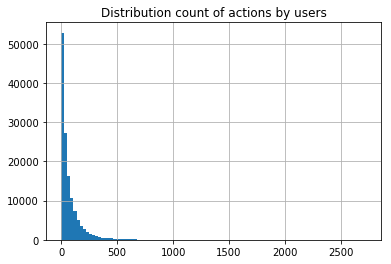

In [11]:
df_sessions.groupby('user_id')['action'].count().hist(bins=100)
plt.title('Distribution count of actions by users')
plt.show()

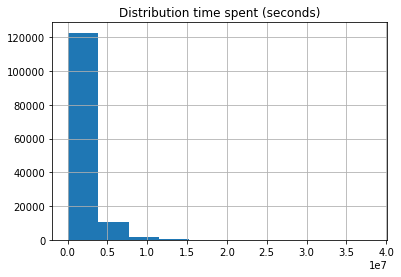

In [12]:
df_sessions.groupby('user_id')['action','secs_elapsed'].agg({'action':'count','secs_elapsed':'sum'})['secs_elapsed'].hist()
plt.title('Distribution time spent (seconds)')
plt.show()
# 1e7 seconds = 10'000'000 seconds= 16'667 minutes = 277 hours = 11.5 days

In [13]:
df_sessions.groupby('user_id')['action','secs_elapsed'].agg({'action':'count','secs_elapsed':'sum'}).describe()

,action,secs_elapsed
count,135483.000000,1.354830e+05
mean,77.159208,1.489732e+06
std,112.092602,1.892923e+06
min,0.000000,0.000000e+00
25%,15.000000,2.605980e+05
50%,40.000000,8.502710e+05
75%,94.000000,2.000422e+06
max,2721.000000,3.822136e+07


In [14]:
df_sessions.groupby('user_id')['action'].count().sort_values(ascending=True).head()

user_id
ug7ttvf60s    0
8aluvsi0c2    0
nzs7nwwc61    0
c9d6256q0a    0
c9rq1git9z    0
Name: action, dtype: int64

In [15]:
df_sessions[df_sessions['user_id'] == '8aluvsi0c2']

,user_id,action,action_type,action_detail,device_type,secs_elapsed
22173,8aluvsi0c2,NaN,message_post,message_post,iPhone,NaN


In [16]:
df_sessions['action_detail'].value_counts()

view_search_results               1776885
p3                                1376550
-unknown-                         1031141
wishlist_content_update            706824
user_profile                       656839
change_trip_characteristics        487744
similar_listings                   364624
user_social_connections            336799
update_listing                     269779
listing_reviews                    269021
dashboard                          152952
user_wishlists                     152672
header_userpic                     141830
message_thread                     132395
edit_profile                       108686
message_post                        87103
contact_host                        81041
unavailable_dates                   77795
confirm_email_link                  58422
create_user                         54878
change_contact_host_dates           52517
user_profile_content_update         50434
user_reviews                        49665
p5                                

### Cleaning, Handling NULLs and data types updates (train and test sets)

In [17]:
df_train.shape

(213451, 16)

In [18]:
df_train.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [19]:
df_train.nunique()

id                         213451
date_account_created         1634
timestamp_first_active     213451
date_first_booking           1976
gender                          4
age                           127
signup_method                   3
signup_flow                    17
language                       25
affiliate_channel               8
affiliate_provider             18
first_affiliate_tracked         7
signup_app                      4
first_device_type               9
first_browser                  52
country_destination            12
dtype: int64

In [20]:
df_train.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [606]:
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])
df_train['date_first_booking'] = pd.to_datetime(df_train['date_first_booking'])
# same for test
df_test['date_account_created'] = pd.to_datetime(df_test['date_account_created'])
df_test['date_first_booking'] = pd.to_datetime(df_test['date_first_booking'])

In [22]:
# date_account_created
df_train['date_account_created'].head()

0   2010-06-28
1   2011-05-25
2   2010-09-28
3   2011-12-05
4   2010-09-14
Name: date_account_created, dtype: datetime64[ns]

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


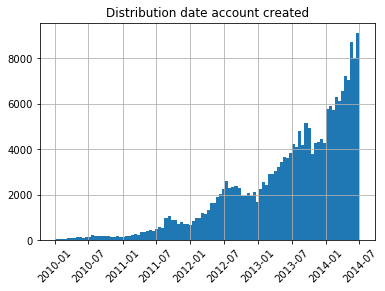

In [23]:
df_train['date_account_created'].hist(xrot=45, bins=100)
plt.title('Distribution date account created')
plt.show()

In [24]:
import datetime as dt
pd.to_datetime(df_train['date_account_created']).dt.to_period('M').head()

0    2010-06
1    2011-05
2    2010-09
3    2011-12
4    2010-09
Name: date_account_created, dtype: period[M]

In [25]:
df_train['timestamp_first_active'].head()

0    20090319043255
1    20090523174809
2    20090609231247
3    20091031060129
4    20091208061105
Name: timestamp_first_active, dtype: int64

In [607]:
df_train['year_first_active'] = df_train['timestamp_first_active'].astype(str).str[:4].astype(int)
df_train['month_first_active'] = df_train['timestamp_first_active'].astype(str).str[4:6].astype(int)
df_train['day_first_active'] = df_train['timestamp_first_active'].astype(str).str[6:8].astype(int)
#df_train['hour_first_active'] = df_train['timestamp_first_active'].astype(str).str[8:10].astype(int)
#df_train['minute_first_active'] = df_train['timestamp_first_active'].astype(str).str[10:12].astype(int)
#df_train['second_first_active'] = df_train['timestamp_first_active'].astype(str).str[12:14].astype(int)

# same for test
df_test['year_first_active'] = df_test['timestamp_first_active'].astype(str).str[:4].astype(int)
df_test['month_first_active'] = df_test['timestamp_first_active'].astype(str).str[4:6].astype(int)
df_test['day_first_active'] = df_test['timestamp_first_active'].astype(str).str[6:8].astype(int)

In [27]:
# print pd.to_datetime(df_train[['year_first_active', 'month_first_active', 'day_first_active']])
# https://stackoverflow.com/questions/19350806/how-to-convert-columns-into-one-datetime-column-in-pandas

In [608]:
df_train['date_first_active'] = pd.to_datetime(dict(year=df_train.year_first_active, month=df_train.month_first_active, day=df_train.day_first_active))
# same for test
df_test['date_first_active'] = pd.to_datetime(dict(year=df_test.year_first_active, month=df_test.month_first_active, day=df_test.day_first_active))

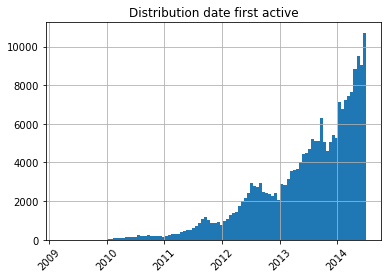

In [29]:
df_train['date_first_active'].hist(xrot=45, bins=100)
plt.title('Distribution date first active')
plt.show()

In [30]:
df_train['date_first_booking'].head()

0          NaT
1          NaT
2   2010-08-02
3   2012-09-08
4   2010-02-18
Name: date_first_booking, dtype: datetime64[ns]

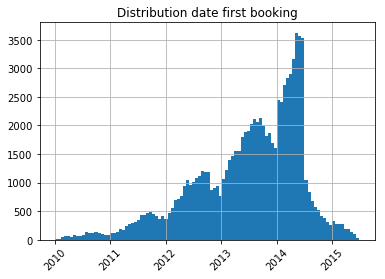

In [31]:
df_train['date_first_booking'].hist(xrot=45, bins=100)
plt.title('Distribution date first booking')
plt.show()

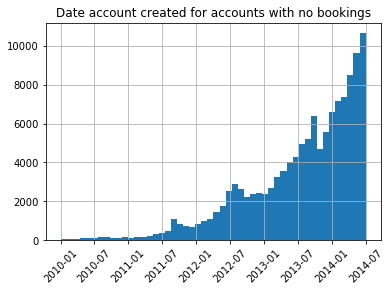

In [32]:
pd.to_datetime(df_train[df_train['date_first_booking'].isnull()]['date_account_created']).hist(xrot=45, bins=50)
plt.title('Date account created for accounts with no bookings')
plt.show()

In [33]:
# all 'date first booking' NULL are output variable NDF (not destination found) - this is a cross-check
df_train[df_train['date_first_booking'].isnull()]['country_destination'].value_counts()

NDF    124543
Name: country_destination, dtype: int64

#### Gender cleaning

In [34]:
df_train['gender'].value_counts()

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

In [609]:
df_train['gender'] = df_train['gender'].replace({'-unknown-':'Not available','OTHER':'Not available'})
# decide to group 'unknown' and 'Other' together as OTHER could be have multple subgroups which we don't have indicatotions

# same for test
df_test['gender'] = df_test['gender'].replace({'-unknown-':'Not available','OTHER':'Not available'})

#### Age cleaning

In [36]:
df_train[df_train['age'] > 100]['age'].value_counts().head(15)
# can we assume age from other parameters?

105.0     1131
2014.0     710
110.0      196
104.0       48
2013.0      39
102.0       34
109.0       31
103.0       26
101.0       23
107.0       23
106.0       17
108.0       15
115.0       13
113.0        4
1949.0       3
Name: age, dtype: int64

In [37]:
df_train['age'].isnull().sum()

87990

In [38]:
df_train[df_train['age'] > 100]['age'].count()

2345

In [39]:
def age_clean(row):
    if row['age'] > 2000:
        return np.nan
    if row['age'] > 1000:
        return 2015 - row['age']
    if row['age'] > 100: # as per age_gender table there is <100 americans (male of female) above the age of 100. Consider those values errors
        return np.nan
    return row['age']

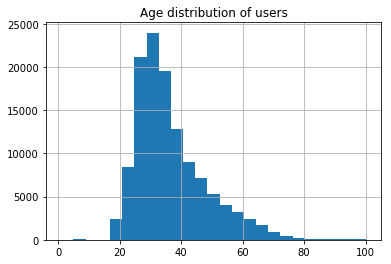

In [40]:
df_train.apply(lambda row: age_clean(row), axis=1).hist(bins=25)
plt.title('Age distribution of users')
plt.show()

In [610]:
df_train['age'] = df_train.apply(lambda row: age_clean(row), axis=1)
# same for test
df_test['age'] = df_test.apply(lambda row: age_clean(row), axis=1)

#### Signup Method

In [272]:
df_train['signup_method'].value_counts()
# clean

basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64

#### Signup flow

In [273]:
df_train['signup_flow'].value_counts()
# categorical variables
# clean

0     164739
25     14659
12      9329
3       8822
2       6881
24      4328
23      2835
1       1047
6        301
8        240
21       196
5         36
20        14
16        11
15        10
10         2
4          1
Name: signup_flow, dtype: int64

#### Language

In [274]:
df_train['language'].value_counts()

en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
th        24
el        24
id        22
hu        18
fi        14
is         5
ca         5
hr         2
Name: language, dtype: int64

In [275]:
df_countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance,destination_language_short
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00,en
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00,en
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61,de
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25,es
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06,fr
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00,en
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40,it
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22,nl
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45,pt
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00,en


#### Affiliate channel

In [276]:
df_train['affiliate_channel'].value_counts()
# clean

direct           137727
sem-brand         26045
sem-non-brand     18844
other              8961
seo                8663
api                8167
content            3948
remarketing        1096
Name: affiliate_channel, dtype: int64

#### Affiliate provider

In [277]:
df_train['affiliate_provider'].value_counts()
# clean

direct                 137426
google                  51693
other                   12549
craigslist               3471
bing                     2328
facebook                 2273
vast                      829
padmapper                 768
facebook-open-graph       545
yahoo                     496
gsp                       453
meetup                    347
email-marketing           166
naver                      52
baidu                      29
yandex                     17
wayn                        8
daum                        1
Name: affiliate_provider, dtype: int64

#### First affiliate tracked

In [278]:
df_train['first_affiliate_tracked'].value_counts()
# clean

untracked        115297
linked            46287
omg               43982
tracked-other      6156
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

In [279]:
df_train[df_train['first_affiliate_tracked'].isnull()]['affiliate_channel'].value_counts()

Series([], Name: affiliate_channel, dtype: int64)

In [611]:
df_train['first_affiliate_tracked'].fillna('untracked', inplace=True)
# same for test
df_test['first_affiliate_tracked'].fillna('untracked', inplace=True)

#### Signup app

In [281]:
df_train['signup_app'].value_counts()
# clean

Web        182717
iOS         19019
Moweb        6261
Android      5454
Name: signup_app, dtype: int64

#### First device type

In [282]:
df_train['first_device_type'].value_counts()

Mac Desktop           89600
Windows Desktop       72716
iPhone                20759
iPad                  14339
Other/Unknown         10667
Android Phone          2803
Android Tablet         1292
Desktop (Other)        1199
SmartPhone (Other)       76
Name: first_device_type, dtype: int64

#### First browser

In [283]:
df_train['first_browser'].value_counts()
# remove unkown and re-group 'others'?

Chrome                  63845
Safari                  45169
Firefox                 33655
-unknown-               27266
IE                      21068
Mobile Safari           19274
Chrome Mobile            1270
Android Browser           851
AOL Explorer              245
Opera                     188
Silk                      124
Chromium                   73
BlackBerry Browser         53
Maxthon                    46
IE Mobile                  36
Apple Mail                 36
Sogou Explorer             33
Mobile Firefox             30
RockMelt                   24
SiteKiosk                  24
Iron                       17
IceWeasel                  13
Pale Moon                  12
CometBird                  11
Yandex.Browser             11
SeaMonkey                  11
Camino                      9
TenFourFox                  8
wOSBrowser                  6
CoolNovo                    6
Avant Browser               4
Opera Mini                  4
Mozilla                     3
Flock     

In [612]:
df_train['first_browser'] = df_train['first_browser'].replace({'-unkown-':'Not available'})
# same for test
df_test['first_browser'] = df_test['first_browser'].replace({'-unkown-':'Not available'})

### Target variable

In [285]:
# target variable
df_train['country_destination'].value_counts(normalize=True)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [286]:
df_train.isnull().sum()

id                                 0
date_account_created               0
timestamp_first_active             0
date_first_booking            124543
gender                             0
age                            90306
signup_method                      0
signup_flow                        0
language                           0
affiliate_channel                  0
affiliate_provider                 0
first_affiliate_tracked            0
signup_app                         0
first_device_type                  0
first_browser                      0
country_destination                0
year_first_active                  0
month_first_active                 0
day_first_active                   0
date_first_active                  0
date_account_created_year          0
date_account_created_month         0
date_first_booking_year       124543
date_first_booking_month      124543
delta_account_to_book         124543
delta_active_to_book          124543
delta_active_to_account            0
d

In [287]:
df_train.dtypes

id                                    object
date_account_created          datetime64[ns]
timestamp_first_active                 int64
date_first_booking            datetime64[ns]
gender                                object
age                                  float64
signup_method                         object
signup_flow                            int64
language                              object
affiliate_channel                     object
affiliate_provider                    object
first_affiliate_tracked               object
signup_app                            object
first_device_type                     object
first_browser                         object
country_destination                   object
year_first_active                      int32
month_first_active                     int32
day_first_active                       int32
date_first_active             datetime64[ns]
date_account_created_year              int64
date_account_created_month             int64
date_first

### Feature engineering

In [288]:
df_train.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination', 'year_first_active',
       'month_first_active', 'day_first_active', 'date_first_active',
       'date_account_created_year', 'date_account_created_month',
       'date_first_booking_year', 'date_first_booking_month',
       'delta_account_to_book', 'delta_active_to_book',
       'delta_active_to_account'],
      dtype='object')

In [289]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,month_first_active,day_first_active,date_first_active,date_account_created_year,date_account_created_month,date_first_booking_year,date_first_booking_month,delta_account_to_book,delta_active_to_book,delta_active_to_account
0,gxn3p5htnn,2010-06-28,20090319043255,NaT,Not available,NaN,facebook,0,en,direct,...,3,19,2009-03-19,2010,6,NaN,NaN,NaN,NaN,466
1,820tgsjxq7,2011-05-25,20090523174809,NaT,MALE,38.0,facebook,0,en,seo,...,5,23,2009-05-23,2011,5,NaN,NaN,NaN,NaN,732
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,...,6,9,2009-06-09,2010,9,2010.0,8.0,-57.0,419.0,476
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,10,31,2009-10-31,2011,12,2012.0,9.0,278.0,1043.0,765
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,Not available,41.0,basic,0,en,direct,...,12,8,2009-12-08,2010,9,2010.0,2.0,-208.0,72.0,280


#### Dates

In [614]:
df_train['date_account_created'].dt.to_period('M').head()

0    2010-06
1    2011-05
2    2010-09
3    2011-12
4    2010-09
Name: date_account_created, dtype: period[M]

In [615]:
# create 'year' and 'month' features for each dates
# date_account_created
df_train['date_account_created_year'] = df_train['date_account_created'].dt.year
df_train['date_account_created_month'] = df_train['date_account_created'].dt.month
# date_first_booking
df_train['date_first_booking_year'] = df_train['date_first_booking'].dt.year
df_train['date_first_booking_month'] = df_train['date_first_booking'].dt.month
# date_first_active (already exists)
# year_first_active
# month_first_active

# same for test
# date_account_created
df_test['date_account_created_year'] = df_test['date_account_created'].dt.year
df_test['date_account_created_month'] = df_test['date_account_created'].dt.month
# date_first_booking
df_test['date_first_booking_year'] = df_test['date_first_booking'].dt.year
df_test['date_first_booking_month'] = df_test['date_first_booking'].dt.month

In [616]:
# create days delta
df_train['delta_account_to_book'] = (df_train['date_first_booking'] - df_train['date_account_created']).dt.days
df_train['delta_active_to_book'] = (df_train['date_first_booking'] - df_train['date_first_active']).dt.days
df_train['delta_active_to_account'] = (df_train['date_account_created'] - df_train['date_first_active']).dt.days

# same for test
df_test['delta_account_to_book'] = (df_test['date_first_booking'] - df_test['date_account_created']).dt.days
df_test['delta_active_to_book'] = (df_test['date_first_booking'] - df_test['date_first_active']).dt.days
df_test['delta_active_to_account'] = (df_test['date_account_created'] - df_test['date_first_active']).dt.days

In [293]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,month_first_active,day_first_active,date_first_active,date_account_created_year,date_account_created_month,date_first_booking_year,date_first_booking_month,delta_account_to_book,delta_active_to_book,delta_active_to_account
0,gxn3p5htnn,2010-06-28,20090319043255,NaT,Not available,NaN,facebook,0,en,direct,...,3,19,2009-03-19,2010,6,NaN,NaN,NaN,NaN,466
1,820tgsjxq7,2011-05-25,20090523174809,NaT,MALE,38.0,facebook,0,en,seo,...,5,23,2009-05-23,2011,5,NaN,NaN,NaN,NaN,732
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,...,6,9,2009-06-09,2010,9,2010.0,8.0,-57.0,419.0,476
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,10,31,2009-10-31,2011,12,2012.0,9.0,278.0,1043.0,765
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,Not available,41.0,basic,0,en,direct,...,12,8,2009-12-08,2010,9,2010.0,2.0,-208.0,72.0,280


In [370]:
df_train[df_train['date_first_active'] == '2014'][['date_first_active','date_account_created','delta_active_to_account']].head()
# always same date in 2014. New policy in place?

,date_first_active,date_account_created,delta_active_to_account
137021,2014-01-01,2014-01-01,0
137022,2014-01-01,2014-01-01,0
137023,2014-01-01,2014-01-01,0
137024,2014-01-01,2014-01-01,0
137025,2014-01-01,2014-01-01,0


In [295]:
df_train.isnull().sum()

id                                 0
date_account_created               0
timestamp_first_active             0
date_first_booking            124543
gender                             0
age                            90306
signup_method                      0
signup_flow                        0
language                           0
affiliate_channel                  0
affiliate_provider                 0
first_affiliate_tracked            0
signup_app                         0
first_device_type                  0
first_browser                      0
country_destination                0
year_first_active                  0
month_first_active                 0
day_first_active                   0
date_first_active                  0
date_account_created_year          0
date_account_created_month         0
date_first_booking_year       124543
date_first_booking_month      124543
delta_account_to_book         124543
delta_active_to_book          124543
delta_active_to_account            0
d

#### Sessions

In [296]:
df_sessions.nunique()

user_id          135483
action              359
action_type          10
action_detail       155
device_type          14
secs_elapsed     337661
dtype: int64

In [297]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [298]:
df_sessions['action_type'].value_counts()

view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

In [299]:
df_sessions['action'].value_counts().head(20)

show                     2768278
index                     843699
search_results            725226
personalize               706824
search                    536057
ajax_refresh_subtotal     487744
update                    365130
similar_listings          364624
social_connections        339000
reviews                   320591
active                    188036
similar_listings_v2       168788
lookup                    162041
create                    155887
dashboard                 152952
header_userpic            141830
collections               124417
edit                      109083
campaigns                 105028
track_page_view            81117
Name: action, dtype: int64

In [300]:
df_sessions['action_type'].value_counts()

view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

In [301]:
df_sessions['device_type'].value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [302]:
# df_sessions.groupby(['user_id'])['action','action_type','action_detail','secs_elapsed'].agg({'action':'nunique','action_type':'nunique','action_detail':'nunique','secs_elapsed':'sum'})

In [303]:
# total time spend, total actions and device used
df_sessions_total = df_sessions.groupby('user_id')['action','secs_elapsed','device_type'].agg({'action':'nunique','secs_elapsed':'sum','device_type':'nunique'})

In [304]:
df_sessions_total.sort_values(by='secs_elapsed', ascending=False).head()

,action,secs_elapsed,device_type
user_id,,,
llvyczd9hn,20,38221363.0,5
yu5bdalz2b,54,31393292.0,3
xboy92k1s2,38,29469461.0,5
wyv1imf8qw,15,28960128.0,3
fsa2gw8kk4,15,26647578.0,1


In [305]:
df_sessions_total.nunique()

action              70
secs_elapsed    128280
device_type          6
dtype: int64

In [306]:
# primary secondary device
df_session_device = df_sessions.groupby(['user_id','device_type'])['secs_elapsed'].sum().to_frame().sort_values(by=['user_id','secs_elapsed'], ascending=[True,False]).reset_index()

In [307]:
df_session_device['rank'] = df_session_device.groupby(['user_id']).cumcount() + 1

In [308]:
df_session_device.head()

,user_id,device_type,secs_elapsed,rank
0,00023iyk9l,iPhone,572254.0,1
1,00023iyk9l,Mac Desktop,295642.0,2
2,0010k6l0om,Mac Desktop,586543.0,1
3,001wyh0pz8,Android App Unknown Phone/Tablet,282965.0,1
4,0028jgx1x1,-unknown-,297010.0,1


In [309]:
df_session_device.nunique()

user_id         135483
device_type         14
secs_elapsed    158872
rank                 6
dtype: int64

In [310]:
df_session_device_prim = df_session_device[df_session_device['rank'] == 1]
df_session_device_second = df_session_device[df_session_device['rank'] == 2]

In [311]:
df_session_device_prim.nunique()

user_id         135483
device_type         14
secs_elapsed    128214
rank                 1
dtype: int64

In [312]:
# primary secondary action based on number of actions
df_session_action = df_sessions.groupby(['user_id','action'])['secs_elapsed'].count().to_frame().sort_values(by=['user_id','secs_elapsed'], ascending=[True,False]).reset_index()
df_session_action['rank'] = df_session_action.groupby(['user_id']).cumcount() + 1
df_session_action_prim = df_session_action[df_session_action['rank'] == 1]
df_session_action_second = df_session_action[df_session_action['rank'] == 2]

In [313]:
df_session_action_prim.nunique()

user_id         135043
action             178
secs_elapsed       555
rank                 1
dtype: int64

In [314]:
# action type
df_sessions_action_type = df_sessions.groupby(['user_id','action_type'])['action'].count().reset_index().pivot_table(index='user_id', columns='action_type', values='action').fillna(0).reset_index()

In [315]:
# issue with merging
df_sessions_users = pd.merge(df_sessions_total.rename(columns={'action':'total_action','secs_elapsed':'total_time','device_type':'total_device'}).reset_index()\
         ,df_session_device_prim[['user_id','device_type']],how='left',on='user_id')
df_sessions_users = df_sessions_users.merge(df_session_device_second[['user_id','device_type']],how='left',on='user_id',suffixes=('_prim','_sec'))
df_sessions_users = df_sessions_users.merge(df_session_action_prim[['user_id','action']],how='left',on='user_id')
df_sessions_users = df_sessions_users.merge(df_session_action_second[['user_id','action']],how='left',on='user_id',suffixes=('_prim','_sec'))
df_sessions_users = df_sessions_users.merge(df_sessions_action_type,how='left',on='user_id')

In [316]:
df_sessions_users.head()

,user_id,total_action,total_time,total_device,device_type_prim,device_type_sec,action_prim,action_sec,-unknown-,booking_request,booking_response,click,data,message_post,modify,partner_callback,submit,view
0,00023iyk9l,13,867896.0,2,iPhone,Mac Desktop,show,requested,0.0,1.0,0.0,4.0,9.0,0.0,0.0,1.0,0.0,21.0
1,0010k6l0om,11,586543.0,1,Mac Desktop,NaN,show,ajax_refresh_subtotal,5.0,0.0,0.0,16.0,9.0,0.0,0.0,1.0,0.0,17.0
2,001wyh0pz8,10,282965.0,1,Android App Unknown Phone/Tablet,NaN,search,show,6.0,0.0,0.0,66.0,2.0,0.0,0.0,0.0,3.0,8.0
3,0028jgx1x1,5,297010.0,2,-unknown-,Android Phone,show,search,1.0,0.0,0.0,9.0,5.0,0.0,0.0,0.0,1.0,15.0
4,002qnbzfs5,25,6487080.0,2,iPhone,-unknown-,show,search,184.0,1.0,0.0,140.0,140.0,9.0,0.0,0.0,15.0,216.0


In [317]:
df_sessions_users.shape

(135483, 18)

#### re-group feature with high cardinality

In [318]:
df_train[['signup_method','signup_flow','affiliate_channel','affiliate_provider','first_affiliate_tracked','signup_app','first_device_type','first_browser']].nunique()

signup_method               3
signup_flow                17
affiliate_channel           8
affiliate_provider         18
first_affiliate_tracked     7
signup_app                  4
first_device_type           9
first_browser              52
dtype: int64

In [319]:
df_first_browser_group = df_train['first_browser'].value_counts().to_frame().reset_index()
df_first_browser_group.head()

,index,first_browser
0,Chrome,63845
1,Safari,45169
2,Firefox,33655
3,-unknown-,27266
4,IE,21068


In [320]:
def browser_group(row):
    if row['first_browser'] < 30: # keeping only browser with at least 30 data points
        return 'other'
    return row['index']

In [321]:
df_first_browser_group['first_browser_group'] = df_first_browser_group.apply(lambda row: browser_group(row), axis=1)
df_first_browser_group.tail()

,index,first_browser,first_browser_group
47,Outlook 2007,1,other
48,Epic,1,other
49,Stainless,1,other
50,Arora,1,other
51,Google Earth,1,other


#### Languages

* languages (match languages with closest destination) and potentially create "other" group

In [322]:
df_train['language'].value_counts()

en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
th        24
el        24
id        22
hu        18
fi        14
is         5
ca         5
hr         2
Name: language, dtype: int64

In [323]:
def language(row):
    if row['destination_language '] == 'eng':
        return 'en'
    if row['destination_language '] == 'deu':
        return 'de'
    if row['destination_language '] == 'spa':
        return 'es'
    if row['destination_language '] == 'fra':
        return 'fr'
    if row['destination_language '] == 'ita':
        return 'it'
    if row['destination_language '] == 'nld':
        return 'nl'
    if row['destination_language '] == 'por':
        return 'pt'
    return 'other'

In [324]:
df_countries['destination_language_short'] = df_countries.apply(lambda row: language(row), axis=1)

In [325]:
df_countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance,destination_language_short
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00,en
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00,en
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61,de
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25,es
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06,fr
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00,en
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40,it
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22,nl
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45,pt
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00,en


In [326]:
df_countries_deduped = df_countries[['language_levenshtein_distance','destination_language_short']].drop_duplicates()
df_countries_deduped

,language_levenshtein_distance,destination_language_short
0,0.00,en
2,72.61,de
3,92.25,es
4,92.06,fr
6,89.40,it
7,63.22,nl
8,95.45,pt


### Final table
* add data from:
    * df_countries (language_levenshtein_distance)
    * df_first_browser_group (first_browser_group)
    * df_sessions_users (mutliple features)

In [327]:
df_train.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination', 'year_first_active',
       'month_first_active', 'day_first_active', 'date_first_active',
       'date_account_created_year', 'date_account_created_month',
       'date_first_booking_year', 'date_first_booking_month',
       'delta_account_to_book', 'delta_active_to_book',
       'delta_active_to_account'],
      dtype='object')

In [618]:
df_test.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'year_first_active', 'month_first_active',
       'day_first_active', 'date_first_active', 'date_account_created_year',
       'date_account_created_month', 'date_first_booking_year',
       'date_first_booking_month', 'delta_account_to_book',
       'delta_active_to_book', 'delta_active_to_account'],
      dtype='object')

In [619]:
df_train_all = df_train.merge(df_countries_deduped, how='left', left_on='language', right_on='destination_language_short')
df_train_all = df_train_all.merge(df_first_browser_group[['index','first_browser_group']], how='left', left_on='first_browser', right_on='index')
df_train_all = df_train_all.merge(df_sessions_users, how='left', left_on='id', right_on='user_id')
# same for test
df_test_all = df_test.merge(df_countries_deduped, how='left', left_on='language', right_on='destination_language_short')
df_test_all = df_test_all.merge(df_first_browser_group[['index','first_browser_group']], how='left', left_on='first_browser', right_on='index')
df_test_all = df_test_all.merge(df_sessions_users, how='left', left_on='id', right_on='user_id')

In [329]:
df_train_all.shape

(213451, 49)

In [620]:
df_test_all.shape

(62096, 48)

In [330]:
df_sessions_users['user_id'].nunique()

135483

In [331]:
df_train_all.isnull().sum()

id                                    0
date_account_created                  0
timestamp_first_active                0
date_first_booking               124543
gender                                0
age                               90306
signup_method                         0
signup_flow                           0
language                              0
affiliate_channel                     0
affiliate_provider                    0
first_affiliate_tracked               0
signup_app                            0
first_device_type                     0
first_browser                         0
country_destination                   0
year_first_active                     0
month_first_active                    0
day_first_active                      0
date_first_active                     0
date_account_created_year             0
date_account_created_month            0
date_first_booking_year          124543
date_first_booking_month         124543
delta_account_to_book            124543


In [356]:
df_train_all[~df_train_all['user_id'].isnull()]['year_first_active'].value_counts()

2014    73815
Name: year_first_active, dtype: int64

In [621]:
df_train_all_final = df_train_all[~df_train_all['user_id'].isnull()]

In [358]:
df_train_all_final.isnull().sum()

id                                   0
date_account_created                 0
timestamp_first_active               0
date_first_booking               45041
gender                               0
age                              32951
signup_method                        0
signup_flow                          0
language                             0
affiliate_channel                    0
affiliate_provider                   0
first_affiliate_tracked              0
signup_app                           0
first_device_type                    0
first_browser                        0
country_destination                  0
year_first_active                    0
month_first_active                   0
day_first_active                     0
date_first_active                    0
date_account_created_year            0
date_account_created_month           0
date_first_booking_year          45041
date_first_booking_month         45041
delta_account_to_book            45041
delta_active_to_book     

In [359]:
df_train_all[df_train_all['user_id'].isnull()].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,-unknown-,booking_request,booking_response,click,data,message_post,modify,partner_callback,submit,view
0,gxn3p5htnn,2010-06-28,20090319043255,NaT,Not available,NaN,facebook,0,en,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,20090523174809,NaT,MALE,38.0,facebook,0,en,seo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,Not available,41.0,basic,0,en,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [360]:
df_train_all['first_browser_group'].value_counts()

Chrome                63845
Safari                45169
Firefox               33655
-unknown-             27266
IE                    21068
Mobile Safari         19274
Chrome Mobile          1270
Android Browser         851
AOL Explorer            245
other                   189
Opera                   188
Silk                    124
Chromium                 73
BlackBerry Browser       53
Maxthon                  46
Apple Mail               36
IE Mobile                36
Sogou Explorer           33
Mobile Firefox           30
Name: first_browser_group, dtype: int64

### Final columns

In [626]:
df_train_all_final.shape

(73815, 49)

In [627]:
df_test_all.shape
# country_destination not included

(62096, 48)

In [628]:
to_removed = ['date_account_created','delta_active_to_account','timestamp_first_active','date_first_booking','date_first_active','destination_language_short','index','first_browser','user_id','-unkown-'\
             ,'date_first_booking_year','date_first_booking_month','delta_account_to_book','delta_active_to_book','booking_request','booking_response','message_post','modify']
to_keep_cont = ['age','language_levenshtein_distance','total_action','total_time',\
                'total_device','click','data','partner_callback','submit','view']
to_keep_cat = ['gender','signup_method','signup_flow','language','affiliate_channel','affiliate_provider','first_affiliate_tracked','signup_app',\
               'first_device_type','first_browser_group','device_type_prim','device_type_sec','action_prim','action_sec','year_first_active'\
               ,'month_first_active','day_first_active','date_account_created_year','date_account_created_month']
# to_keep_ord = []
output = ['country_destination']

#### Dates

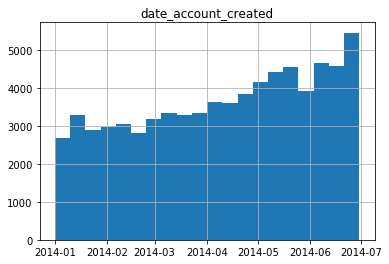

In [339]:
df_train_all_final['date_account_created'].hist(bins=20)
plt.title('date_account_created')
plt.show()
# to removed and use day-month-year

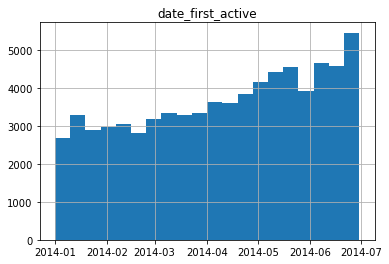

In [340]:
df_train_all_final['date_first_active'].hist(bins=20)
plt.title('date_first_active')
plt.show()
# to removed and use day-month-year

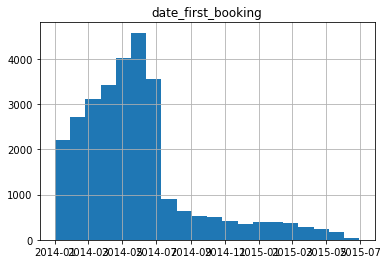

In [341]:
df_train_all_final['date_first_booking'].hist(bins=20)
plt.title('date_first_booking')
plt.show()

#### Continous features
* normalize
* check outliers

In [538]:
df_train_all_final[to_keep_cont].isnull().sum()

age                              0
language_levenshtein_distance    0
total_action                     0
total_time                       0
total_device                     0
click                            3
data                             3
partner_callback                 3
submit                           3
view                             3
dtype: int64

In [629]:
df_train_all_final['age'].fillna(value=0, inplace=True)
# same for test
df_test_all['age'].fillna(value=0, inplace=True)

C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


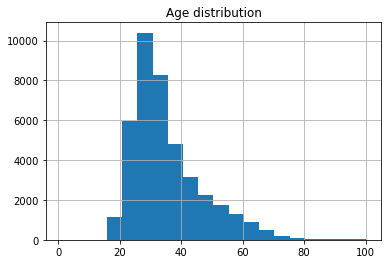

In [373]:
df_train_all_final['age'].hist(bins=20)
plt.title('Age distribution')
plt.show()

In [380]:
df_train_all_final[df_train_all_final['language_levenshtein_distance'].isnull()]['language'].value_counts()

zh    726
ko    386
ru    143
ja    102
sv     43
pl     20
tr     18
da     16
cs     12
th     12
el      9
id      9
no      8
hu      5
fi      5
is      3
ca      2
Name: language, dtype: int64

In [631]:
df_train_all_final['language_levenshtein_distance'].fillna(value=1,inplace=True)
# same for test
df_test_all['language_levenshtein_distance'].fillna(value=1,inplace=True)

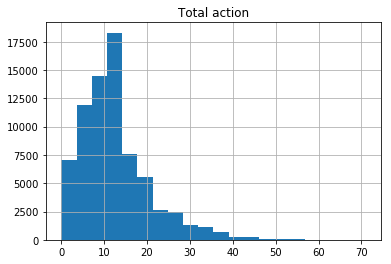

In [383]:
df_train_all_final['total_action'].hist(bins=20)
plt.title('Total action')
plt.show()

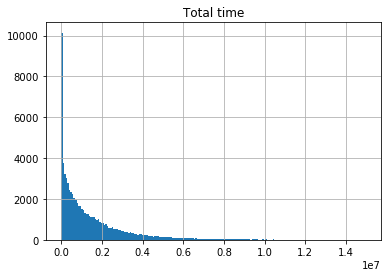

In [424]:
df_train_all_final[df_train_all_final['total_time'] < 15000000]['total_time'].hist(bins=200)
plt.title('Total time')
plt.show()

In [540]:
# outliers to be removed
idx = df_train_all_final['total_time'] > 15000000
idx.sum()

85

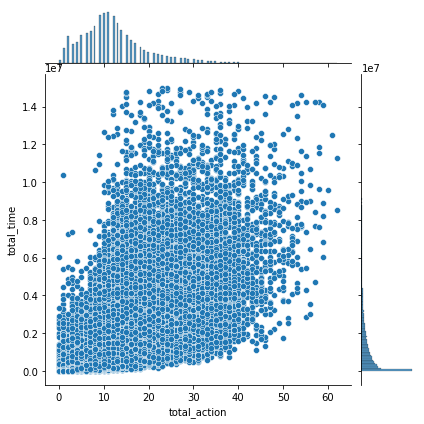

In [541]:
sns.jointplot(x='total_action', y='total_time',data=df_train_all_final[~idx])
plt.show()

In [542]:
df_train_all_final['total_device'].value_counts()

1.0    53789
2.0    17275
3.0     2416
4.0      297
5.0       35
6.0        3
Name: total_device, dtype: int64

In [543]:
# remove
idx = idx | (df_train_all_final['click'].isnull())
idx.sum()

88

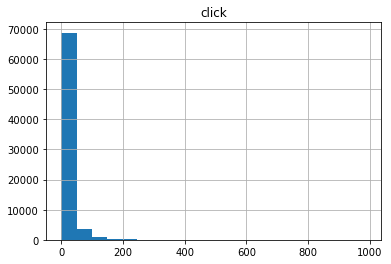

In [544]:
df_train_all_final['click'].hist(bins=20)
plt.title('click')
plt.show()

In [545]:
(df_train_all_final['click'] > 300).sum()

88

In [546]:
idx = idx | (df_train_all_final['click'] > 300)
idx.sum()

167

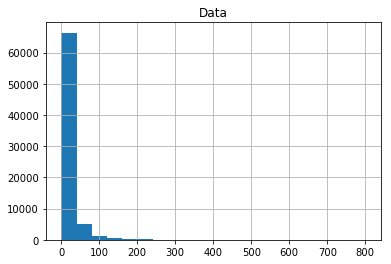

In [547]:
df_train_all_final['data'].hist(bins=20)
plt.title('Data')
plt.show()

In [548]:
idx = idx | (df_train_all_final['data'] > 300)
idx.sum()

211

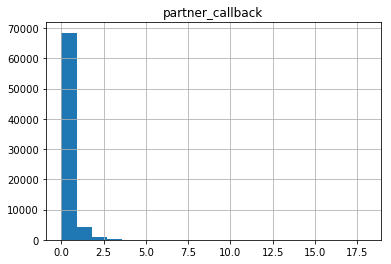

In [549]:
df_train_all_final['partner_callback'].hist(bins=20)
plt.title('partner_callback')
plt.show()

In [550]:
idx = idx | (df_train_all_final['partner_callback'] > 10)
idx.sum()

214

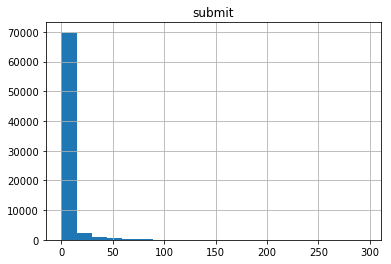

In [551]:
df_train_all_final['submit'].hist(bins=20)
plt.title('submit')
plt.show()

In [552]:
idx = idx | (df_train_all_final['submit'] > 150)
idx.sum()

237

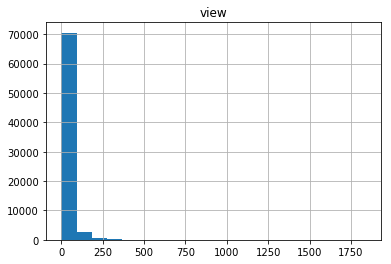

In [553]:
df_train_all_final['view'].hist(bins=20)
plt.title('view')
plt.show()

In [554]:
idx = idx | (df_train_all_final['submit'] > 500)
idx.sum()

237

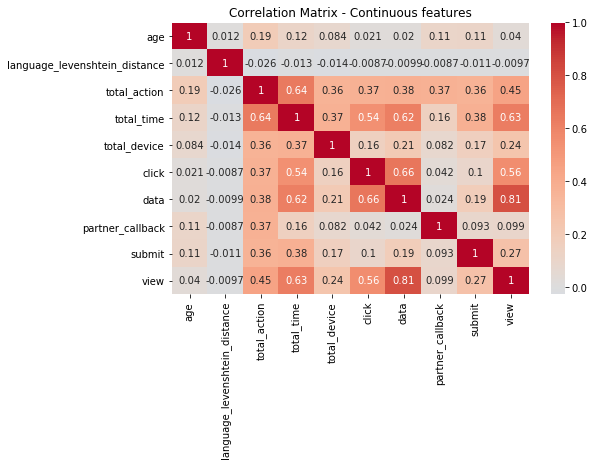

In [555]:
# correlation matrix
# https://datatofish.com/correlation-matrix-pandas/
plt.figure(figsize=(8,5))
corrMatrix = df_train_all_final[~idx][to_keep_cont].corr()
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Continuous features')
plt.show()

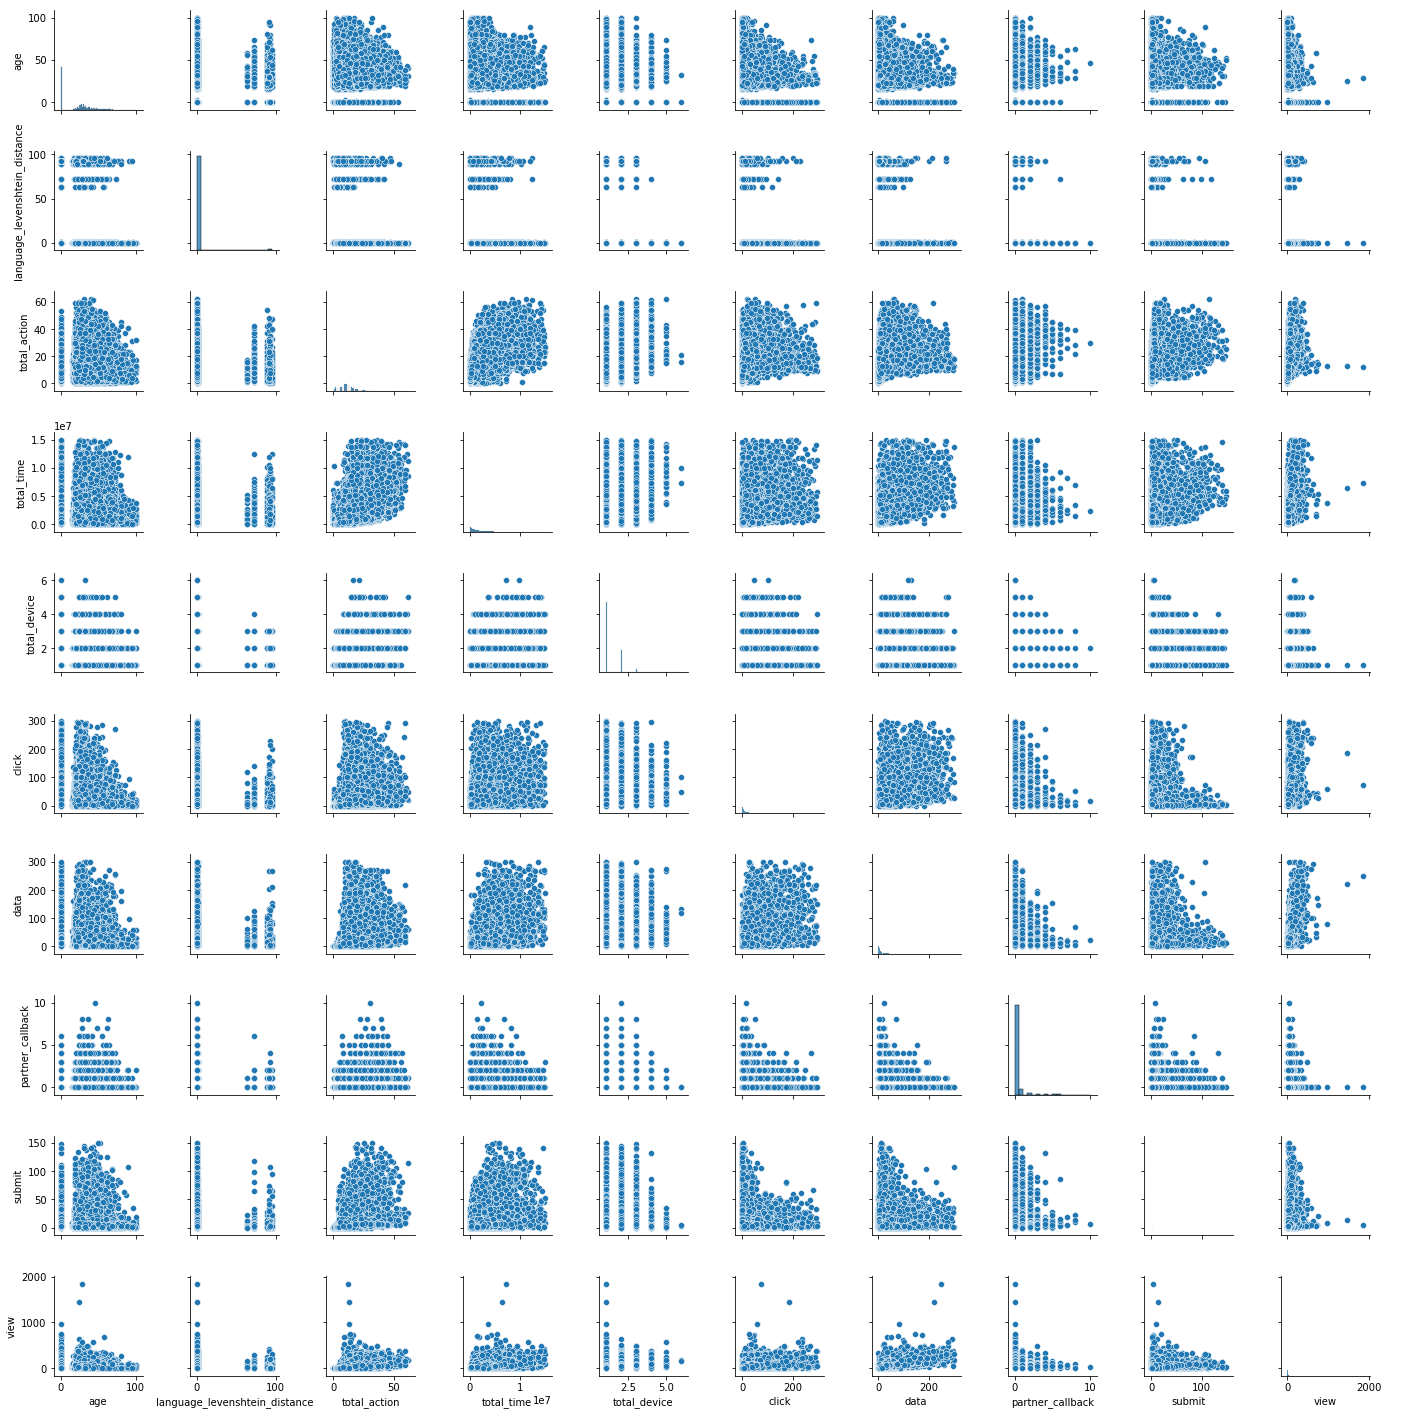

In [556]:
import seaborn as sns
sns.pairplot(df_train_all_final[~idx][to_keep_cont], height=2)
plt.show()

#### Categorical features

In [564]:
df_train_all_final[to_keep_cat].isnull().sum()

gender                        0
signup_method                 0
signup_flow                   0
language                      0
affiliate_channel             0
affiliate_provider            0
first_affiliate_tracked       0
signup_app                    0
first_device_type             0
first_browser_group           0
device_type_prim              0
device_type_sec               0
action_prim                   0
action_sec                    0
year_first_active             0
month_first_active            0
day_first_active              0
date_account_created_year     0
date_account_created_month    0
dtype: int64

In [632]:
df_train_all_final['device_type_sec'].fillna('empty', inplace=True)
df_train_all_final['action_prim'].fillna('empty', inplace=True)
df_train_all_final['action_sec'].fillna('empty', inplace=True)
# same for test
df_test_all['device_type_sec'].fillna('empty', inplace=True)
df_test_all['action_prim'].fillna('empty', inplace=True)
df_test_all['action_sec'].fillna('empty', inplace=True)

In [566]:
# df_train_all_final[to_keep_cat].fillna('empty', inplace=True)

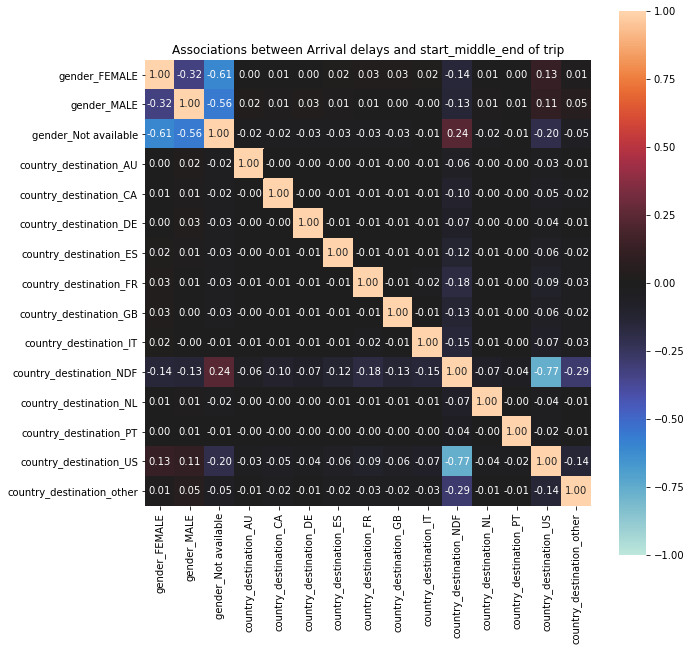

In [567]:
df_associations = pd.get_dummies(df_train_all_final[['gender','country_destination']])
#pip install dython
from dython.nominal import associations # (https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)
# Plot features associations
associations(df_associations,theil_u=True, figsize=(10, 10), title='Associations between Arrival delays and start_middle_end of trip')
plt.show()

### Build models

In [633]:
# one-hot-encoding for categorical variables
encoded_df_tr = pd.get_dummies(data=df_train_all_final[~idx][to_keep_cat+to_keep_cont+output], columns=to_keep_cat)
# test
encoded_df_te = pd.get_dummies(data=df_test_all[to_keep_cat+to_keep_cont], columns=to_keep_cat)

In [635]:
print('Shape train:',encoded_df_tr.shape)
print('Shape train:',encoded_df_te.shape)

Shape train: (73578, 540)
Shape train: (62096, 481)


In [636]:
# arrival set
train_list = encoded_df_tr.columns.tolist()
test_list = encoded_df_te.columns.tolist()

# identify columns which are in train set but not in valid or test sets
for x in train_list:
    if x in test_list: continue
    else:
        print(x)

country_destination
signup_flow_24
language_is
affiliate_channel_api
device_type_sec_Opera Phone
action_prim_10
action_prim_airbnb_picks
action_prim_ajax_get_referrals_amt
action_prim_ajax_google_translate
action_prim_ajax_referral_banner_experiment_type
action_prim_ajax_referral_banner_type
action_prim_ajax_worth
action_prim_apply
action_prim_apply_coupon_error
action_prim_badge
action_prim_cancellation_policy_click
action_prim_change
action_prim_change_currency
action_prim_clickthrough
action_prim_concierge
action_prim_confirmation
action_prim_delete
action_prim_domains
action_prim_email_itinerary_colorbox
action_prim_friends
action_prim_google_importer
action_prim_home_safety_landing
action_prim_hosting_social_proof
action_prim_multi
action_prim_my
action_prim_my_listings
action_prim_new_session
action_prim_other_hosting_reviews
action_prim_other_hosting_reviews_first
action_prim_phone_verification_number_submitted_for_call
action_prim_photography
action_prim_qt_reply_v2
action_prim

In [637]:
encoded_df_te_reindex = encoded_df_te.reindex(columns=encoded_df_tr.columns,fill_value=0.0)

In [664]:
encoded_df_te_reindex.fillna(value=0,inplace=True)
print(encoded_df_te_reindex.isnull().sum().sum())

0


In [665]:
print('Shape train:',encoded_df_tr.shape)
print('Shape train:',encoded_df_te.shape)
print('Shape train:',encoded_df_te_reindex.shape)

Shape train: (73578, 540)
Shape train: (62096, 481)
Shape train: (62096, 540)


In [666]:
# create input(X) and output(y)
X = encoded_df_tr.drop(columns='country_destination').values
y = encoded_df_tr.country_destination.values
# test
X_te = encoded_df_te_reindex.drop(columns='country_destination').values

In [667]:
# standardization for continous features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X)
X_te_rescaled = scaler.transform(X_te)

In [668]:
# split train and validation
from sklearn.model_selection import train_test_split
X_tr, X_va, y_tr, y_va = train_test_split(X_rescaled, y, test_size=0.2, random_state=10)

In [669]:
print('Train set X shape:',X_tr.shape)
print('Valid set X shape:',X_va.shape)
print('Train set y shape:',y_tr.shape)
print('Valid set y shape:',y_va.shape)

Train set X shape: (58862, 539)
Valid set X shape: (14716, 539)
Train set y shape: (58862,)
Valid set y shape: (14716,)


In [670]:
# output imbalanced
df_train_all_final['country_destination'].value_counts()

NDF      45041
US       20095
other     3655
FR        1435
IT         979
GB         731
ES         707
CA         440
DE         250
NL         247
AU         152
PT          83
Name: country_destination, dtype: int64

In [671]:
# baseline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
base = DummyClassifier()
base.fit(X_tr, y_tr)
print('Baseline accuracy: {:.3f}'.format(base.score(X_va, y_va)))
# print('Baseline f1_score: {:.3f}'.format(f1_score(y_true=y_va, y_pred=base.predict(X_va))))

Baseline accuracy: 0.611


In [672]:
base.predict(X_va)

array(['NDF', 'NDF', 'NDF', ..., 'NDF', 'NDF', 'NDF'], dtype='<U3')

In [673]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

In [674]:
dt = DecisionTreeClassifier()
dt.fit(X_tr, y_tr)
print('DecisionTree accuracy: {:.3f}'.format(dt.score(X_va, y_va)))

DecisionTree accuracy: 0.561


In [675]:
# logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_tr, y_tr)
print('LogisticRegression accuracy: {:.3f}'.format(logreg.score(X_va, y_va)))

LogisticRegression accuracy: 0.672


C:\Users\glaurent\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [676]:
# randomforest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [677]:
rf.fit(X_tr, y_tr)
print('RandomForestClassifier accuracy: {:.3f}'.format(rf.score(X_va, y_va)))

RandomForestClassifier accuracy: 0.681


In [678]:
pd.DataFrame(rf.predict(X_va))[0].value_counts()

NDF      10767
US        3944
other        4
FR           1
Name: 0, dtype: int64

In [679]:
pd.DataFrame(y_va)[0].value_counts()

NDF      8986
US       4065
other     677
FR        300
IT        168
GB        143
ES        126
CA         98
DE         57
NL         55
AU         28
PT         13
Name: 0, dtype: int64

In [682]:
df_test_predict = pd.DataFrame(rf.predict(X_te))

In [687]:
df_test_predict['id'] = df_test['id']

In [692]:
df_test_sub = df_test_predict[['id',0]].rename(columns={0:'country'})

In [698]:
df_test_sub.to_csv('airbnb_test_sub.csv', index=False)

## Comments
* To reach better performance would need to do better feature engineering as well as hyperparamters tuning in the ML model
    * feautre engineering would probably have been better and more straight forward to handle NULL values with '-1' as suggest in some of the documentation
    * Still wondering how I could have better used session data as we were missing data before 2010
    * also wondering if for NULL or missing values (e.g.: age) I could have used ML models to predict or if this is adding instability to final ML model which would already based on ML
    * Basic hyperparameter tuning would probably have already significantly improve performance
* reading other codes and ideas after I had done the project I see more advanced techniques with multiple layers which could be used

#### Good related codes and articles
https://www.kaggle.com/svpons/script-0-8655/commentshttps://www.kaggle.com/svpons/script-0-8655/comments
<br>https://www.kaggle.com/svpons/three-level-classification-architecture